## Setup

In [1]:
import sys
import os
sys.path.append(os.path.join("..", ".."))
import model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
shapefile = os.path.join("..", "..", "data", "census")
pop_df = pd.read_csv(os.path.join(shapefile, "censo_PHV_2010.csv"),
                     usecols=['RADIO', 'PERSONAS'],
                     dtype={'RADIO':str, 'PERSONAS':float})

## Data Generation

In [3]:
N0 = 1000
T = 200
step_fraction = 40
seed=39
distance_cutoff = 0.1
pop_join_left_on='cod_rad'
pop_join_right_on='RADIO'
pop_col='PERSONAS'

if False:
    import geopandas
    import pandas as pd
    sim = dict(map=geopandas.read_file(shapefile))
    if pop_df is None:
        population = None
    else:
        population = pd.merge(
            sim["map"],
            pop_df,
            left_on=pop_join_left_on,
            right_on=pop_join_right_on,
            how="inner",
        )[pop_col]
    sim["location"] = model.sim.location.simulate_position(
        sim["map"]["geometry"], N0=N0, T=T, seed=seed, step_fraction=step_fraction, population=population, n_jobs=-1
    )
    sim["patients"] = pd.DataFrame({"patient": np.unique(sim["location"]["patient"])})
    sim["dates"] = pd.DataFrame({"date": np.unique(sim["location"]["date"])})

    distance_cutoff = distance_cutoff
    sim["contacts"] = model.sim.contacts.calculate_contacts(sim, distance_cutoff=distance_cutoff)

    distance_cutoff = distance_cutoff
    sim["contacts"] = sim["contacts"].loc[sim["contacts"]['distance'] < distance_cutoff]
    sim["N_c"] = model.sim.contacts.calculate_Nc(sim)

Calculating positions...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 985 out of 985 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 501.2min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 525.4min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 550.6min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 581.8min


Calculated positions in 36081.09 seconds.


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 597.6min finished


In [89]:
if True:
    distance_cutoff = 0.1
    sim["contacts"] = sim["contacts"].loc[sim["contacts"]['distance'] < distance_cutoff]
    sim["N_c"] = model.sim.contacts.calculate_Nc(sim)
    print(sim["N_c"])

0.32305


In [90]:
if True:
    sim["states"], sim["tests"] = model.sim.state.simulate_states(sim, N_infected=1)
    sim["hospital"] = model.sim.state.get_first_occurrence(sim["states"], 6)
    sim["deaths"] = model.sim.state.get_first_occurrence(sim["states"], 8)

Calculating states...
t = 0; 1 infectious; 21 exposed; 999 susceptible; 0 dead
t = 20; 3 infectious; 2 exposed; 975 susceptible; 0 dead
t = 40; 3 infectious; 0 exposed; 970 susceptible; 0 dead
t = 60; 1 infectious; 0 exposed; 967 susceptible; 0 dead
t = 80; 5 infectious; 2 exposed; 944 susceptible; 0 dead
t = 100; 27 infectious; 7 exposed; 872 susceptible; 0 dead
t = 120; 40 infectious; 9 exposed; 752 susceptible; 0 dead
t = 140; 21 infectious; 4 exposed; 701 susceptible; 1 dead
t = 160; 5 infectious; 0 exposed; 687 susceptible; 1 dead
t = 180; 2 infectious; 0 exposed; 683 susceptible; 1 dead
Calculated states in 2.82 seconds.


In [ ]:
try:
    raise FileNotFoundError
    sim = model.sim.load_pickle()
except FileNotFoundError:
    sim = model.sim.simulate(
        shapefile=shapefile, 
        N0=N0,
        T=T, 
        N_infected=1, 
        step_fraction=step_fraction, 
        distance_cutoff=distance_cutoff, 
        seed=seed
    )

Calculating positions...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 19.5min


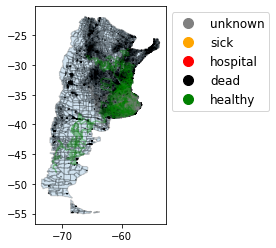

<Figure size 432x288 with 0 Axes>

In [58]:
model.sim.plot_sim(sim, patients = np.arange(10), color='known_status')
plt.savefig("sample_known_status.png")

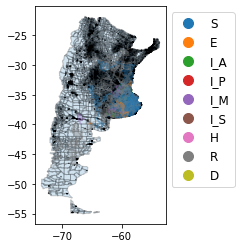

<Figure size 432x288 with 0 Axes>

In [59]:
model.sim.plot_sim(sim, patients = np.arange(10), color='state')
plt.savefig("sample_true_state.png")

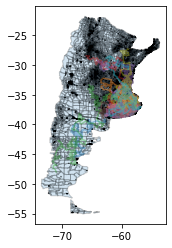

<Figure size 432x288 with 0 Axes>

In [60]:
model.sim.plot_sim(sim, patients = np.arange(10), color='patient')
plt.savefig("sample_patient_id.png")

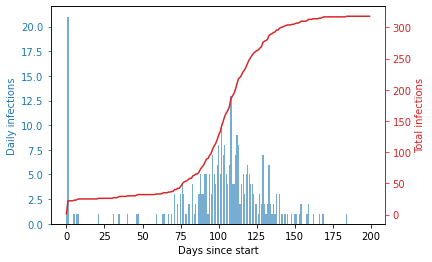

In [91]:
model.sim.plot_infections(sim)
plt.savefig("infection_rate.png")

KeyboardInterrupt: 

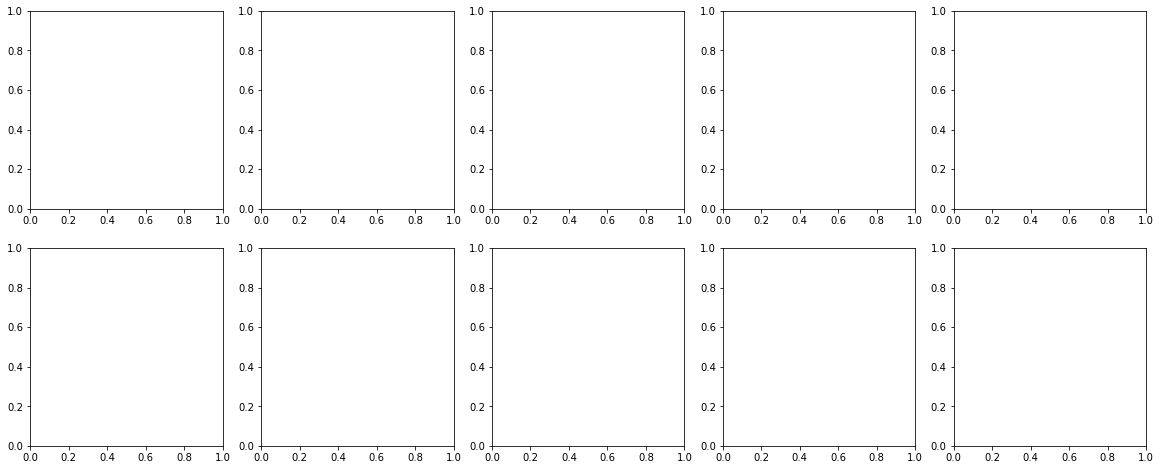

In [62]:
model.sim.plot_heatmap(sim)
plt.savefig("infectious_population_density.png")

In [105]:
sim['location'].head()

,patient,date,latitude,longitude
0,0,0,-58.779060,-38.240365
1,0,1,-58.043287,-38.073462
2,0,2,-57.635063,-37.138803
3,0,3,-57.023364,-36.783210
4,0,4,-57.273058,-37.248642


In [106]:
sim['tests'].head()

,patient,date,result
0,619,0,True
1,622,0,True
2,623,0,True
3,624,0,True
4,625,0,True


In [107]:
sim['hospital'].head()

,patient,date
13,765,19
4,112,85
7,173,85
11,344,97
10,333,103


In [108]:
sim['deaths'].head()

,patient,date
0,955,135


In [109]:
model.sim.io.save_pickle(sim)
#model.sim.io.save_csv(sim)

## Disease spread modeling

For model specification, see the [README](../../README.md)

In [110]:
import pandas as pd
negative_tests = sim['tests'].loc[np.logical_not(sim['tests']['result'])][['patient', 'date']]
negative_tests['outcome'] = 'negative'
positive_tests = sim['tests'].loc[sim['tests']['result']][['patient', 'date']]
positive_tests['outcome'] = 'positive'
hospital = sim['hospital'].copy()
hospital['outcome'] = 'hospital'
deaths = sim['deaths'].copy()
deaths['outcome'] = 'dead'
outcomes = pd.concat([positive_tests, negative_tests, hospital, deaths])

In [111]:
from joblib import Parallel, delayed

def calculate_centrality(p, contacts):
    return np.sum([np.logical_or(contacts['patient1'] == p, contacts['patient2']==p)])

centrality = np.array(Parallel(10)(delayed(calculate_centrality)(p, sim['contacts'])
                       for p in sim['patients']['patient']))

In [112]:
centrality = pd.DataFrame({'centrality':centrality})
centrality.index.name = 'patient'

In [113]:
# set the initial state -- at present everyone is probably healthy
state = model.model.initial_state(sim)

In [148]:
# evaluate contacts each day and update the model
curr_date = 70
save_states = np.arange(15)
saved_states = {}
for date in sim["dates"]["date"]:
    state = model.model.next_state(sim, state, date, distance_cutoff=0.006)
    if date in save_states + curr_date:
        saved_states[date - curr_date] = state
    elif date > np.max(save_states) + curr_date:
        break

In [149]:
BETA0 = model.constants.beta0
output = pd.DataFrame(columns = ['patient', 'date', 'state', 'scenario', 'prob'])

In [150]:
for i in save_states:
    for j, name in model.model.STATES.items():
        output = pd.concat([output, pd.DataFrame({
            'patient':np.arange(saved_states[i].shape[0]),
            'date':i, 
            'state':name, 
            'scenario':'moderate', 
            'prob':saved_states[i][:,j]
        })])

In [151]:
model.constants.beta0 = BETA0 * 0.1
state = model.model.initial_state(sim)
for date in sim["dates"]["date"]:
    state = model.model.next_state(sim, state, date, distance_cutoff=0.006)
    if date in save_states + curr_date:
        saved_states[date - curr_date] = state
    elif date > np.max(save_states) + curr_date:
        break

for i in save_states:
    for j, name in model.model.STATES.items():
        output = pd.concat([output, pd.DataFrame({
            'patient':np.arange(saved_states[i].shape[0]),
            'date':i, 
            'state':name, 
            'scenario':'optimistic', 
            'prob':saved_states[i][:,j]
        })])

In [152]:
model.constants.beta0 = BETA0 * 1.2
state = model.model.initial_state(sim)
for date in sim["dates"]["date"]:
    state = model.model.next_state(sim, state, date, distance_cutoff=0.006)
    if date in save_states + curr_date:
        saved_states[date - curr_date] = state
    elif date > np.max(save_states) + curr_date:
        break

for i in save_states:
    for j, name in model.model.STATES.items():
        output = pd.concat([output, pd.DataFrame({
            'patient':np.arange(saved_states[i].shape[0]),
            'date':i, 
            'state':name, 
            'scenario':'pessimistic', 
            'prob':saved_states[i][:,j]
        })])

In [153]:
model.constants.beta0 = BETA0
sim['location'].to_csv("location.csv")
sim['contacts'].to_csv("contacts.csv")
outcomes.to_csv("outcomes.csv")
output.to_csv("output.csv")
centrality.to_csv("centrality.csv")

In [144]:
output.loc[(output['patient'] == 996) & (output['date'] == 10) & (output['state'] == 'S')]

,patient,date,state,scenario,prob
996,996,10,S,moderate,0.0
996,996,10,S,optimistic,0.0
996,996,10,S,pessimistic,0.0
996,996,10,S,optimistic,0.0


In [68]:
# print the final model state
with np.printoptions(threshold=np.inf):
    print(state.round(3))

[[0.    0.    0.    0.    0.    0.    0.    0.8   0.2  ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.003 0.    0.01  0.969 0.018]
 [0.    0.    0.    0.    0.    0.    0.001 0.979 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.002 0.978 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.166 0.667 0.167]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.001 0.979 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.014 0.789 0.197]
 [0.    0.    0.    0.    0.   

In [ ]:
output.loc[(output['date'] == 10) & (output['state'] == 'S'), ['prob']].hist()

In [70]:
sim['states'][:,-1]

array([7., 7., 7., 7., 0., 7., 7., 7., 0., 7., 7., 7., 7., 7., 7., 7., 7.,
       0., 0., 7., 7., 7., 7., 0., 7., 0., 7., 0., 7., 7., 7., 7., 7., 0.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 0., 7., 0., 7., 7., 7., 0., 7.,
       5., 7., 7., 7., 7., 0., 7., 7., 7., 7., 7., 7., 7., 7., 7., 0., 7.,
       7., 7., 7., 0., 0., 7., 7., 7., 0., 0., 7., 7., 7., 0., 7., 7., 7.,
       0., 0., 7., 7., 7., 7., 0., 0., 0., 7., 7., 7., 0., 7., 7., 4., 7.,
       7., 0., 7., 7., 0., 7., 7., 7., 7., 7., 0., 0., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 8., 0., 0., 8., 7., 7., 0., 7., 7.,
       0., 7., 7., 7., 0., 7., 0., 7., 7., 7., 0., 7., 7., 0., 7., 7., 0.,
       7., 7., 0., 7., 2., 7., 0., 7., 0., 0., 0., 7., 7., 0., 0., 7., 0.,
       0., 7., 7., 7., 0., 0., 7., 7., 7., 7., 7., 7., 7., 7., 0., 0., 7.,
       0., 0., 7., 0., 7., 0., 7., 0., 7., 7., 7., 7., 7., 7., 0., 0., 7.,
       7., 7., 7., 7., 7., 7., 0., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 0., 7., 7.